In [1]:
from datasets import Dataset, Features, ClassLabel, Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import ImageDraw, ImageFont
import torch.optim as optim
import os
import torch
from IPython.display import Image as IImage, display
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import datetime
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy
import PIL.Image as PILImage
from tqdm import tqdm

2025-06-07 11:30:58.736444: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 11:30:58.752503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749288658.768273  146688 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749288658.772859  146688 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 11:30:58.791143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
data_dir = os.path.join('data', 'pokemon')
image_paths = []
labels = []

class_names = sorted(os.listdir(data_dir))
label_map = {name: idx for idx, name in enumerate(class_names)}

for class_name in tqdm(class_names):
    class_dir = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for file_name in os.listdir(class_dir):
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_dir, file_name))
            labels.append(label_map[class_name])

data_dict = {"image": image_paths, "label": labels}

features = Features({
    "image": Image(),
    "label": ClassLabel(names=class_names)
})

dataset = Dataset.from_dict(data_dict, features=features)

100%|██████████| 898/898 [00:02<00:00, 358.34it/s]


In [3]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2503
})

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(([0.5, 0.5, 0.5]), ([0.5, 0.5, 0.5]))
])

transform_eval = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
class PokeNet(nn.Module):
    def __init__(self, num_classes):
        super(PokeNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class TDataset(TorchDataset):
    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"]
        label = sample["label"]


        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split["train"]
test_dataset = split["test"]

train_td = TDataset(train_dataset, transform=transform_train)
test_td = TDataset(test_dataset, transform=transform_eval)

train_loader = DataLoader(train_td, batch_size=32, shuffle=True,
                          num_workers=8, pin_memory=True)

test_loader = DataLoader(test_td, batch_size=32, shuffle=True,
                         num_workers=8, pin_memory=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PokeNet(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

accuracy = MulticlassAccuracy(num_classes=len(class_names), average='micro').to(device)

In [11]:
log_dir = f"runs/pokemon_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir=log_dir)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    accuracy.reset()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = torch.argmax(outputs, dim=1)
        accuracy.update(preds, targets)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy.compute().item()

    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("Accuracy/train", epoch_acc, epoch)

writer.close()

Epoch 1: Loss = 6.8314, Accuracy = 0.0005
Epoch 2: Loss = 6.5390, Accuracy = 0.0080
Epoch 3: Loss = 6.1502, Accuracy = 0.0095
Epoch 4: Loss = 5.8274, Accuracy = 0.0180
Epoch 5: Loss = 5.5379, Accuracy = 0.0210
Epoch 6: Loss = 5.2730, Accuracy = 0.0295
Epoch 7: Loss = 5.0337, Accuracy = 0.0305
Epoch 8: Loss = 4.8560, Accuracy = 0.0420
Epoch 9: Loss = 4.6444, Accuracy = 0.0415
Epoch 10: Loss = 4.5245, Accuracy = 0.0629
Epoch 11: Loss = 4.3596, Accuracy = 0.0644
Epoch 12: Loss = 4.2510, Accuracy = 0.0719
Epoch 13: Loss = 4.1128, Accuracy = 0.0794
Epoch 14: Loss = 4.0258, Accuracy = 0.1059
Epoch 15: Loss = 3.8588, Accuracy = 0.1199
Epoch 16: Loss = 3.7714, Accuracy = 0.1334
Epoch 17: Loss = 3.6560, Accuracy = 0.1334
Epoch 18: Loss = 3.6179, Accuracy = 0.1434
Epoch 19: Loss = 3.5370, Accuracy = 0.1548
Epoch 20: Loss = 3.4320, Accuracy = 0.1818
Epoch 21: Loss = 3.3433, Accuracy = 0.1923
Epoch 22: Loss = 3.2644, Accuracy = 0.1973
Epoch 23: Loss = 3.1413, Accuracy = 0.2123
Epoch 24: Loss = 3.1

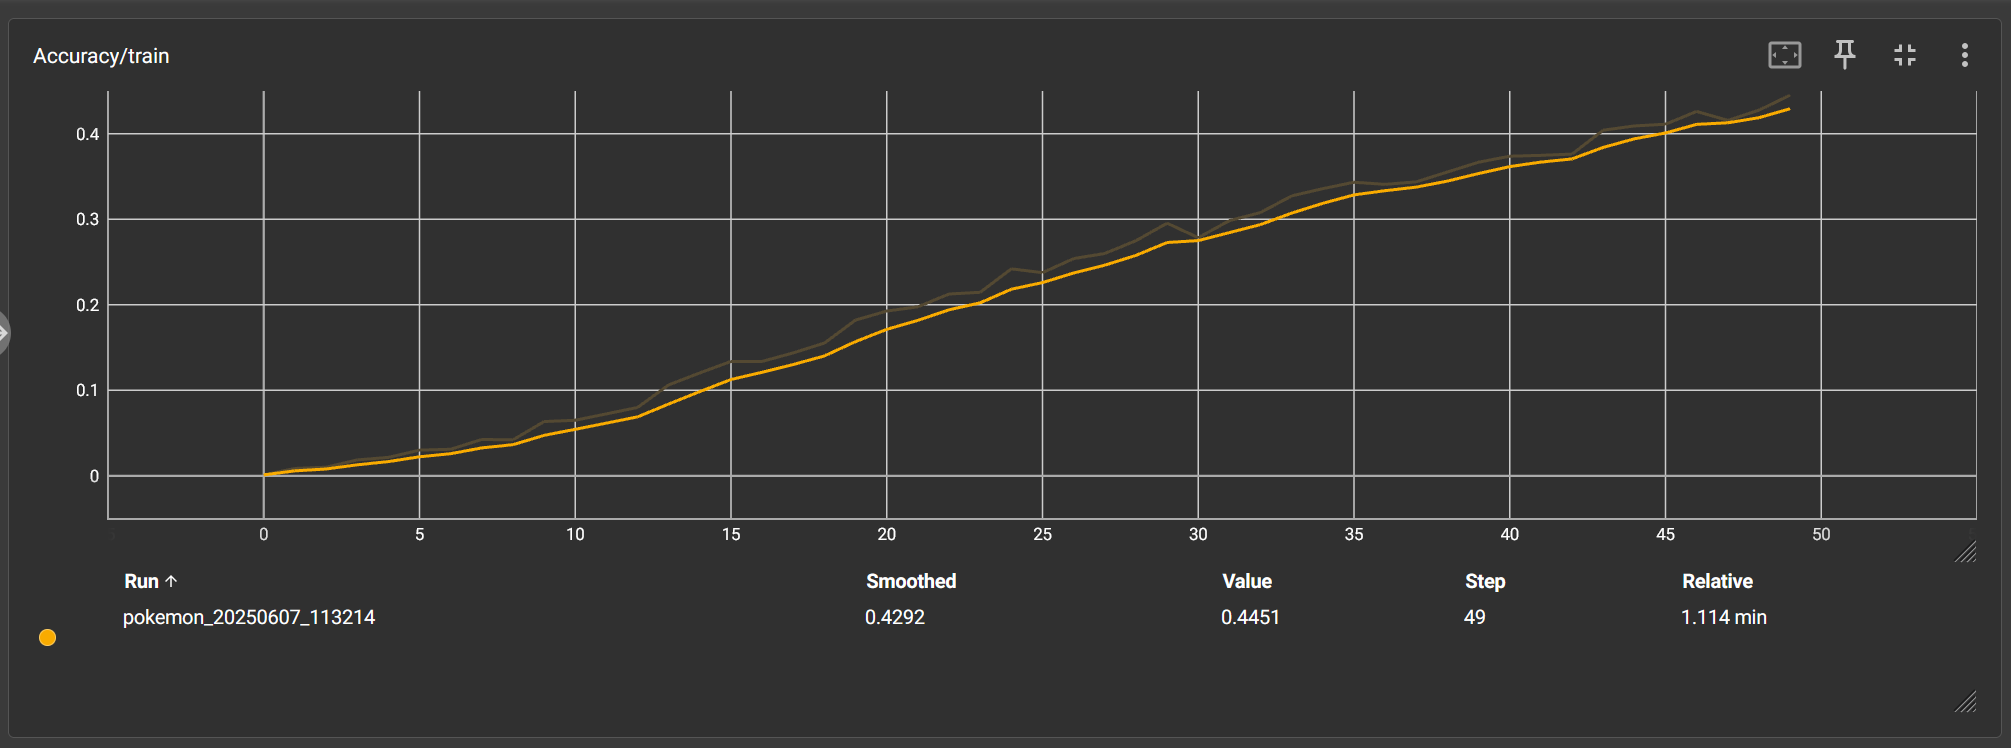

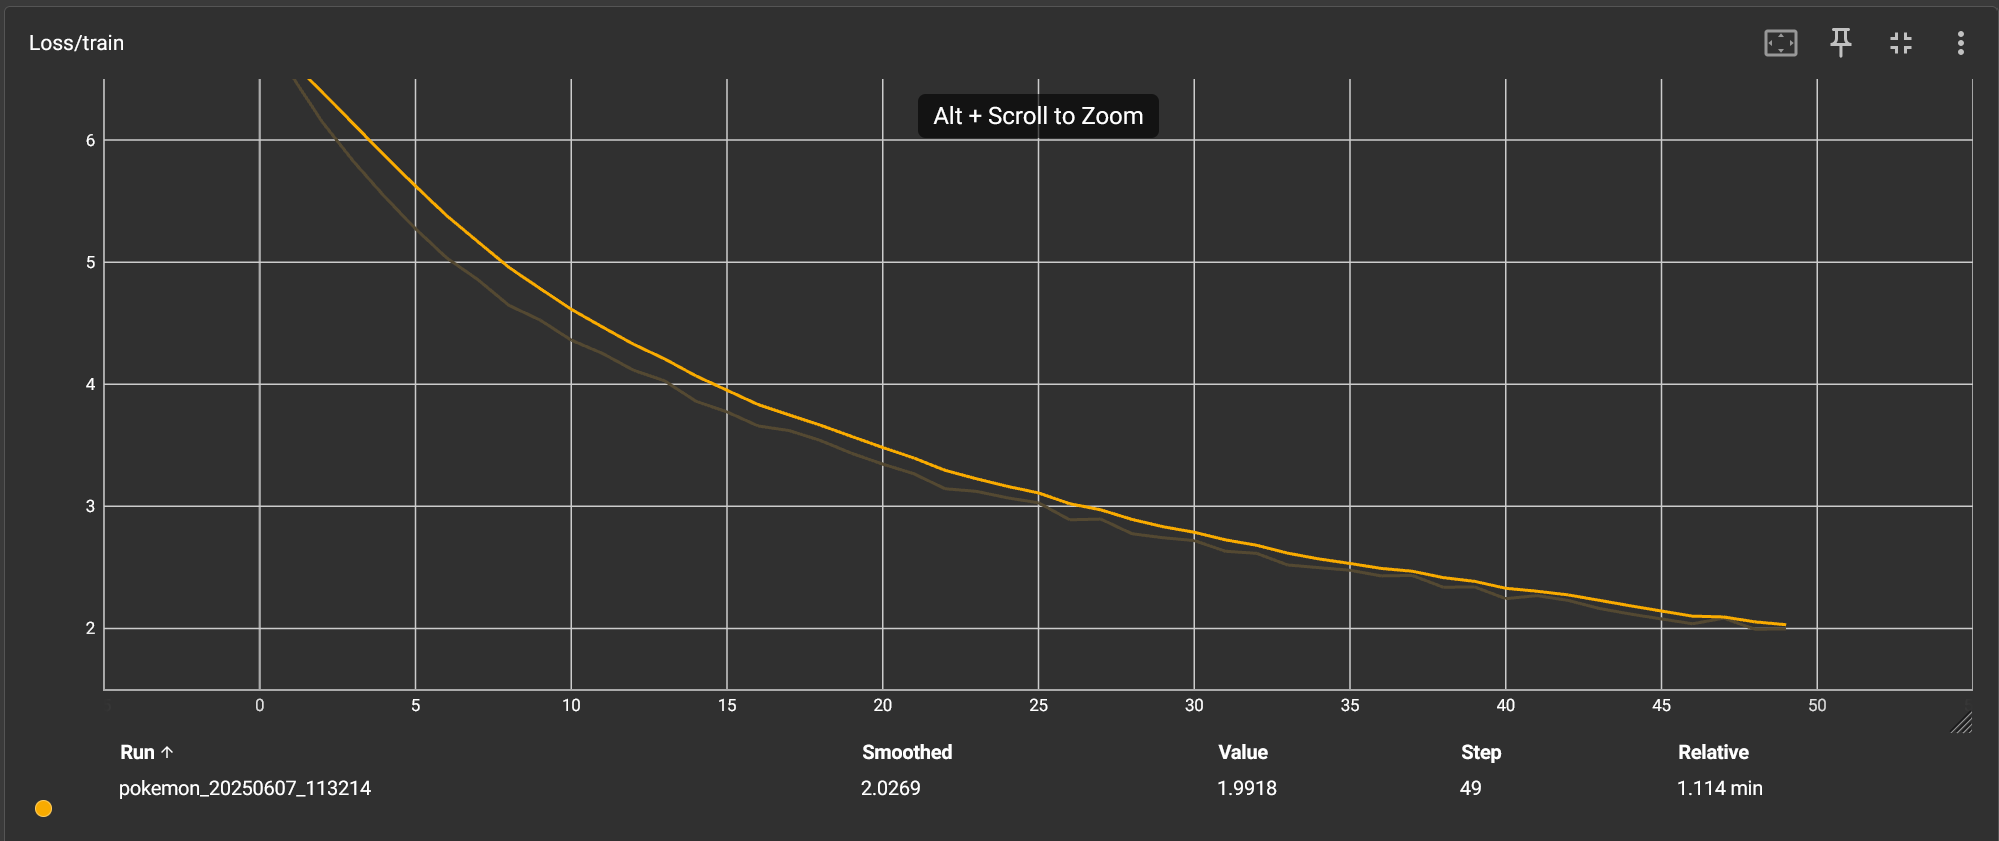

In [25]:
display(IImage(filename='train_acc.png'))
display(IImage(filename='train_loss.png'))

In [13]:
torch.save(model.state_dict(), "poke_model.pth")

In [59]:
inference_model = PokeNet(num_classes=len(class_names)).to(device)
inference_model.load_state_dict(torch.load("poke_model.pth", map_location=device))
inference_model.eval()

test_acc = MulticlassAccuracy(num_classes=len(class_names), average='micro').to(device)

all_results = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = inference_model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        preds = torch.argmax(probabilities, dim=1)

        test_acc.update(preds, targets)

        for i in range(len(inputs)):
            image = inputs[i].cpu()
            pred = preds[i].item()
            label = targets[i].item()
            prob = probabilities[i][pred].item()
            all_results.append((image, pred, label, prob))

final_accuracy = test_acc.compute().item()
print(f"Test Accuracy: {final_accuracy:.4f}")

100%|██████████| 16/16 [00:00<00:00, 26.92it/s]

Test Accuracy: 0.1377


In [34]:
def denormalize(img_tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return torch.clamp(img_tensor * std + mean, 0, 1)

def add_border_and_text(img_tensor, pred, prob, label, thickness=2):
    img_tensor = denormalize(img_tensor)
    img_tensor = torch.clamp(img_tensor, 0, 1)

    pil_img = TF.to_pil_image(img_tensor)
    img = pil_img.resize((64, 64), resample=PILImage.NEAREST)

    is_correct = pred == label
    border_color = (0, 255, 0) if is_correct else (255, 0, 0)

    canvas_width = img.width + 2 * thickness
    canvas_height = img.height + 2 * thickness + 12  # space for text

    bordered = PILImage.new("RGB", (canvas_width, canvas_height), color=border_color)
    bordered.paste(img, (thickness, thickness))

    draw = ImageDraw.Draw(bordered)

    try:
        font = ImageFont.truetype("arial.ttf", 10)
    except:
        font = ImageFont.load_default()

    text = f"({prob:.1%}"
    draw.text((2, img.height + thickness), text, fill=(0, 0, 0), font=font)

    return TF.to_tensor(bordered)

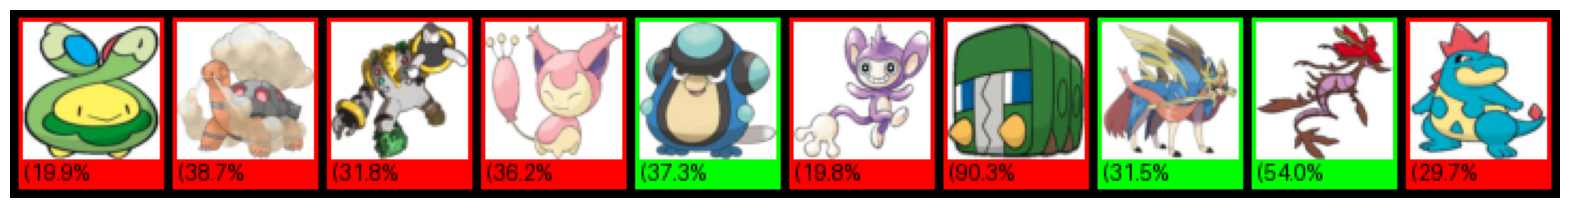

In [60]:
def show_predictions(results, N):
    images = []
    for i in range(min(N, len(results))):
        image, pred, label, prob = results[i]
        img = add_border_and_text(image, pred, prob, label)
        images.append(img)

    grid = make_grid(images, nrow=N, padding=4)
    npimg = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(N * 2, 3))
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

show_predictions(all_results, N=10)

Initially, I've tried to train on grayscale data - resulted in awful performance regardless of the model architecture. Then, I switched to RGB color scheme, and got stable convergence.
To deal with lack of data (2500 samples for 800+ separate classes), I've applied augmentation with regularization techniques while increasing the number of epochs in order to get better results.
Logs reveal multi-class train accuracy of 44,51% and 13,77% in validation.

Bet that with tuned model's architecture (maybe with pretrained backbone) and image transformation, we may achieve better results:)